# Requirements

In [74]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [247]:
dataset = pd.read_csv("urdu-sentiment-corpus-v1.tsv", sep = '\t')
print(dataset.head(10))

                                               Tweet Class
0  میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...     P
1  چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...     N
2                           ٹویٹر کا خیال کیسے آیا ؟     O
3  سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...     P
4    ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ     P
5   گندی زبان اور گٹر جیسے دماغ والے جاهل جیالے ه...     N
6  قاتل بھی تم مقتول بھی تم,ظالم بھی ہم اور مظلوم...     N
7  ﻧﻮﺭ ﺑﻐﺪﺍﺩ ﮐﯽ ﮔﻠﯿﻮﮞ ﮐﺎ ﮨﮯ ﮨﺮ ﺍﯾﮏ ﮐﺮﻥ ﺍﺱ ﮐﯽ ﻣﺪﯾﻨ...     P
8   یہ لفظوں كى شرارت ھے سنبهل کر کچھ بهى لِكهنا ...     P
9  سمارٹ فون کے عادیوں کے لیے ڈجٹل ڈیٹاکس کیپ متع...     P


## Preprocessing

In [248]:
def sentence_preprocessing(sentences):
    # Preprocessing steps
    preprocessed_sentences = []

    for sentence in sentences:
        # Normalization: Convert to lowercase
        sentence = sentence.lower()
        
        # Removing Noise: Remove special characters and symbols
        sentence = re.sub(r'[^\w\s]', '', sentence)
        sentence = re.sub(r'\b\d+\b', '', sentence)
        
        with open('stopwords-ur.txt', 'r', encoding='utf-8') as f:
            stopwords_urdu = f.read().splitlines()
        sentence = ' '.join(word for word in sentence.split() if word not in stopwords_urdu)
        
        preprocessed_sentences.append(sentence)

    return preprocessed_sentences


sentences = dataset['Tweet'].tolist()
processed_sentences = sentence_preprocessing(sentences)
# Display the preprocessed sentences
for i, sentence in enumerate(processed_sentences[:5]):
    print(f"Original: {sentences[i]}")
    print(f"Processed: {sentence}")
    print()


Original: میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب کوٹ لکھپت والی اتفاق فیکٹری میں نہیں بنتا۔ایٹم بم کہوٹہ کی ایٹمی۔۔۔ 
Processed: میں نے ایٹم بم بنایا ھے او بھائی ایٹم بمب کوٹ لکھپت والی اتفاق فیکٹری میں نہیں بنتاایٹم بم کہوٹہ ایٹمی

Original: چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن سکتے 
Processed: چندے سے انقلاب عمران خان وزیر اعظم نہیں بن سکتے

Original:  ٹویٹر کا خیال کیسے آیا ؟
Processed: ٹویٹر کا خیال کیسے آیا

Original: سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000 فٹ کی بلندی پر چھلانگ لگا کر عالمی ریکارڈ قائم کرلیا۔ چھلانگ کی۔۔۔ 
Processed: سرچ انجن گوگل نائب صدر نے فضا میں فٹ بلندی چھلانگ لگا کر عالمی ریکارڈ قائم کرلیا چھلانگ

Original:  ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ
Processed: ابھی اسکی لہریں کبھی کبھی آ جاتی یار أ



In [249]:
dataset['Class'] = dataset['Class'].replace('O','P')

## Train Test Split

In [257]:
labels = dataset['Class'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.75)

training_sentences = processed_sentences[0:training_size]
testing_sentences = processed_sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [259]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the training labels
label_encoder.fit(training_labels)

# Encode training labels
training_labels_final = label_encoder.transform(training_labels)

# Encode testing labels
testing_labels_final = label_encoder.transform(testing_labels)

## Tokenization

In [68]:
embedding_dim = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token (if used)
print("Vocabulary size:", vocab_size)
training_sequences = tokenizer.texts_to_sequences(training_sentences)
max_pad_len = max([len(seq) for seq in training_sequences])
print("Max paded sequence length: ",max_pad_len)
training_padded = pad_sequences(training_sequences, maxlen=max_pad_len, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_pad_len, padding=padding_type, truncating=trunc_type)

Vocabulary size: 4086
Max paded sequence length:  30


## RNN (2 Layers and 0.3 Dropout)

In [75]:
model_rnn_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.SimpleRNN(units=16, activation='tanh', return_sequences=True),  # First layer
    tf.keras.layers.SimpleRNN(units=32, activation='tanh'),  # Second layer
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_rnn_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_rnn_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 16)            65376     
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 30, 16)            528       
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 32)                1568      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 67,505
Trainable params: 67,505
Non-trainable params: 0
_________________________________________________________________


In [80]:
num_epochs = 20
history_rnn_1 = model_rnn_1.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
24/24 [==============================] - 1s 23ms/step - loss: 0.0270 - accuracy: 0.9827 - val_loss: 2.4999 - val_accuracy: 0.4880
Epoch 2/20
24/24 [==============================] - 1s 21ms/step - loss: -0.0036 - accuracy: 0.9947 - val_loss: 2.2728 - val_accuracy: 0.4760
Epoch 3/20
24/24 [==============================] - 0s 18ms/step - loss: 0.0031 - accuracy: 0.9933 - val_loss: 2.1635 - val_accuracy: 0.4800
Epoch 4/20
24/24 [==============================] - 0s 16ms/step - loss: -0.0136 - accuracy: 0.9973 - val_loss: 2.0510 - val_accuracy: 0.5120
Epoch 5/20
24/24 [==============================] - 0s 15ms/step - loss: -0.0130 - accuracy: 0.9973 - val_loss: 2.1094 - val_accuracy: 0.5080
Epoch 6/20
24/24 [==============================] - 0s 15ms/step - loss: -0.0160 - accuracy: 0.9973 - val_loss: 2.2122 - val_accuracy: 0.5160
Epoch 7/20
24/24 [==============================] - 0s 16ms/step - loss: -0.0167 - accuracy: 0.9973 - val_loss: 2.1785 - val_accuracy: 0.5240
Epoch 8/

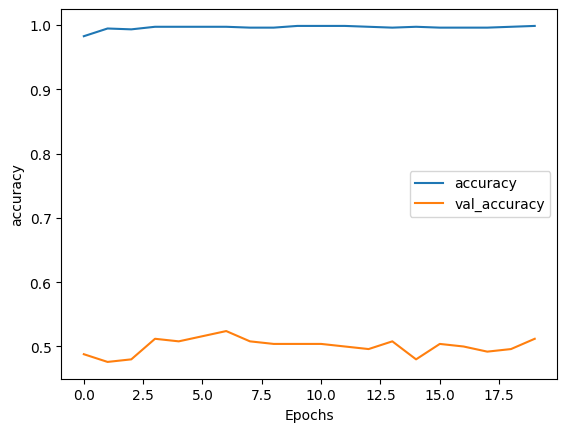

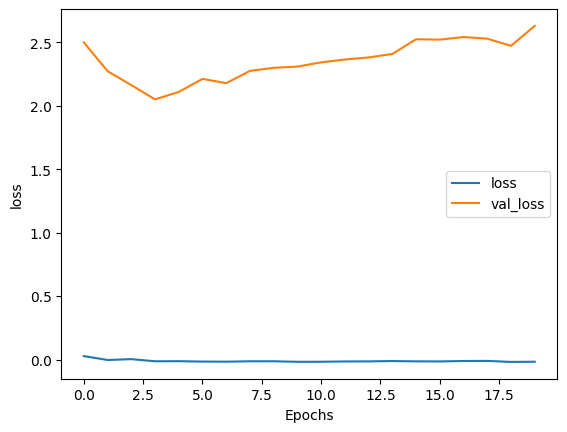

In [82]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_rnn_1, "accuracy")
plot_graphs(history_rnn_1, "loss")

8/8 [==============================] - 0s 7ms/step
Accuracy: 0.512
Precision: 0.5263157894736842
Recall: 0.6153846153846154
F1-score: 0.5673758865248227


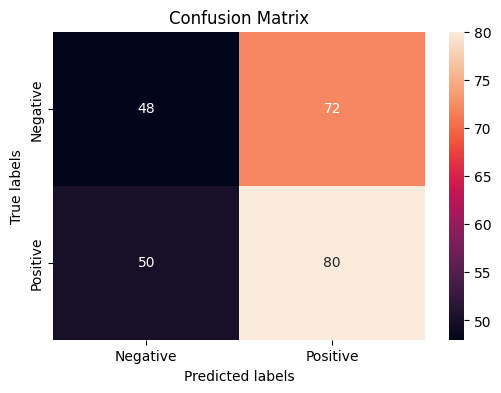

In [85]:
# Predict labels for testing data
predicted_labels = (model_rnn_1.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## RNN (2 Layers and 0.7 Dropout)

In [86]:
model_rnn_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.SimpleRNN(units=16, activation='tanh', return_sequences=True),  # First layer
    tf.keras.layers.SimpleRNN(units=32, activation='tanh'),  # Second layer
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_rnn_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_rnn_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 16)            65376     
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 30, 16)            528       
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 32)                1568      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 67,505
Trainable params: 67,505
Non-trainable params: 0
_________________________________________________________________


In [87]:
num_epochs = 20
history_rnn_2 = model_rnn_2.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
24/24 [==============================] - 4s 36ms/step - loss: 0.7093 - accuracy: 0.5227 - val_loss: 0.6978 - val_accuracy: 0.4880
Epoch 2/20
24/24 [==============================] - 0s 17ms/step - loss: 0.6641 - accuracy: 0.5733 - val_loss: 0.6924 - val_accuracy: 0.5280
Epoch 3/20
24/24 [==============================] - 0s 15ms/step - loss: 0.5700 - accuracy: 0.7000 - val_loss: 0.7397 - val_accuracy: 0.4800
Epoch 4/20
24/24 [==============================] - 0s 16ms/step - loss: 0.3703 - accuracy: 0.8773 - val_loss: 0.7865 - val_accuracy: 0.5320
Epoch 5/20
24/24 [==============================] - 0s 14ms/step - loss: 0.2244 - accuracy: 0.9507 - val_loss: 0.9702 - val_accuracy: 0.4880
Epoch 6/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1327 - accuracy: 0.9720 - val_loss: 1.0613 - val_accuracy: 0.4880
Epoch 7/20
24/24 [==============================] - 0s 15ms/step - loss: 0.0714 - accuracy: 0.9893 - val_loss: 1.1799 - val_accuracy: 0.4840
Epoch 8/20
24

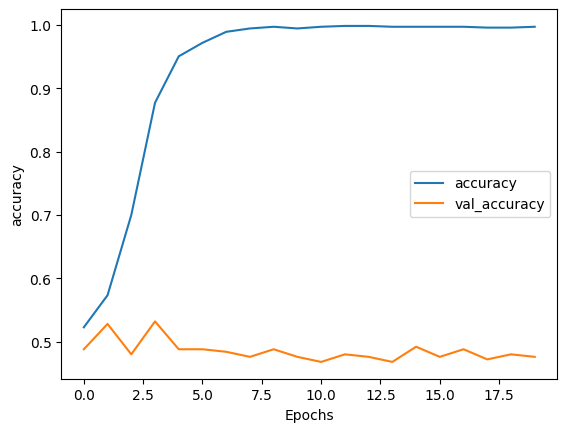

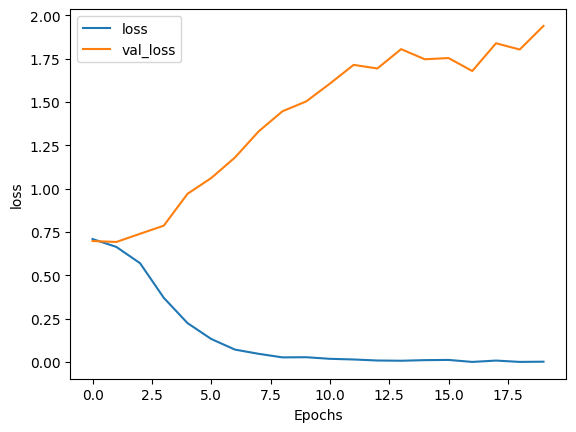

In [88]:
plot_graphs(history_rnn_2, "accuracy")
plot_graphs(history_rnn_2, "loss")

8/8 [==============================] - 0s 8ms/step
Accuracy: 0.476
Precision: 0.4956521739130435
Recall: 0.43846153846153846
F1-score: 0.46530612244897956


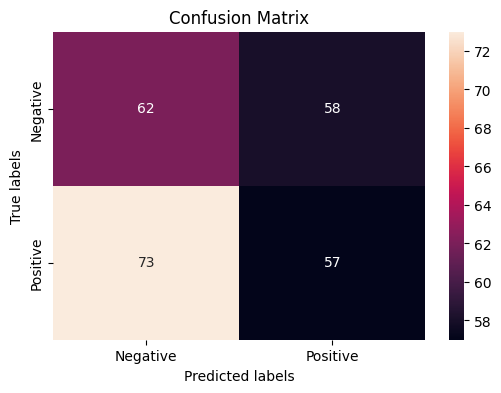

In [89]:
# Predict labels for testing data
predicted_labels = (model_rnn_2.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## RNN (3 Layers and 0.3 Dropout)

In [97]:
model_rnn_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.SimpleRNN(units=16, activation='tanh', return_sequences=True),  # First layer
    tf.keras.layers.SimpleRNN(units=32, activation='tanh', return_sequences=True),  # Second layer
    tf.keras.layers.SimpleRNN(units=16, activation='tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_rnn_3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_rnn_3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 30, 16)            65376     
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 30, 16)            528       
                                                                 
 simple_rnn_24 (SimpleRNN)   (None, 30, 32)            1568      
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 16)                784       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 68,273
Trainable params: 68,273
Non-tra

In [98]:
num_epochs = 20
history_rnn_3 = model_rnn_3.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20


24/24 [==============================] - 5s 51ms/step - loss: 0.7315 - accuracy: 0.4893 - val_loss: 0.7004 - val_accuracy: 0.5160
Epoch 2/20
24/24 [==============================] - 0s 20ms/step - loss: 0.6238 - accuracy: 0.6600 - val_loss: 0.7193 - val_accuracy: 0.4800
Epoch 3/20
24/24 [==============================] - 0s 20ms/step - loss: 0.4496 - accuracy: 0.8267 - val_loss: 0.7647 - val_accuracy: 0.5520
Epoch 4/20
24/24 [==============================] - 1s 21ms/step - loss: 0.2203 - accuracy: 0.9560 - val_loss: 0.8732 - val_accuracy: 0.4920
Epoch 5/20
24/24 [==============================] - 0s 17ms/step - loss: 0.0945 - accuracy: 0.9947 - val_loss: 0.9631 - val_accuracy: 0.5000
Epoch 6/20
24/24 [==============================] - 0s 16ms/step - loss: 0.0476 - accuracy: 0.9960 - val_loss: 1.0601 - val_accuracy: 0.5120
Epoch 7/20
24/24 [==============================] - 0s 15ms/step - loss: 0.0290 - accuracy: 0.9973 - val_loss: 1.1163 - val_accuracy: 0.5080
Epoch 8/20
24/24 [======

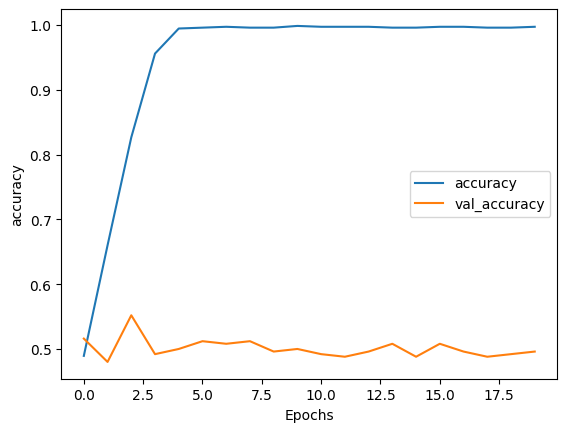

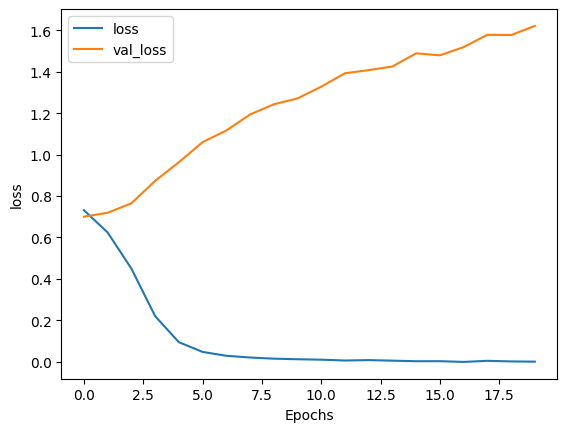

In [99]:
plot_graphs(history_rnn_3, "accuracy")
plot_graphs(history_rnn_3, "loss")

8/8 [==============================] - 1s 10ms/step
Accuracy: 0.496
Precision: 0.5163934426229508
Recall: 0.4846153846153846
F1-score: 0.5


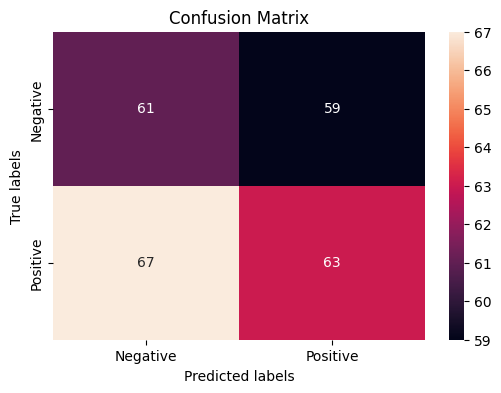

In [100]:
# Predict labels for testing data
predicted_labels = (model_rnn_3.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## RNN (3 Layers and 0.7 Dropout)

In [102]:
model_rnn_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.SimpleRNN(units=16, activation='tanh', return_sequences=True),  # First layer
    tf.keras.layers.SimpleRNN(units=32, activation='tanh', return_sequences=True),  # Second layer
    tf.keras.layers.SimpleRNN(units=16, activation='tanh'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_rnn_4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_rnn_4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 30, 16)            65376     
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 30, 16)            528       
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 30, 32)            1568      
                                                                 
 simple_rnn_28 (SimpleRNN)   (None, 16)                784       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 68,273
Trainable params: 68,273
Non-tra

In [103]:
num_epochs = 20
history_rnn_4 = model_rnn_4.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
24/24 [==============================] - 6s 46ms/step - loss: 0.8250 - accuracy: 0.5187 - val_loss: 0.7131 - val_accuracy: 0.4680
Epoch 2/20
24/24 [==============================] - 0s 19ms/step - loss: 0.6816 - accuracy: 0.5707 - val_loss: 0.7466 - val_accuracy: 0.4480
Epoch 3/20
24/24 [==============================] - 0s 16ms/step - loss: 0.5428 - accuracy: 0.7173 - val_loss: 0.8027 - val_accuracy: 0.4880
Epoch 4/20
24/24 [==============================] - 0s 15ms/step - loss: 0.3720 - accuracy: 0.8573 - val_loss: 0.9128 - val_accuracy: 0.4760
Epoch 5/20
24/24 [==============================] - 0s 16ms/step - loss: 0.2368 - accuracy: 0.9293 - val_loss: 0.9877 - val_accuracy: 0.4920
Epoch 6/20
24/24 [==============================] - 0s 16ms/step - loss: 0.1481 - accuracy: 0.9627 - val_loss: 1.0694 - val_accuracy: 0.5000
Epoch 7/20
24/24 [==============================] - 0s 16ms/step - loss: 0.1088 - accuracy: 0.9787 - val_loss: 1.2132 - val_accuracy: 0.5080
Epoch 8/20
24

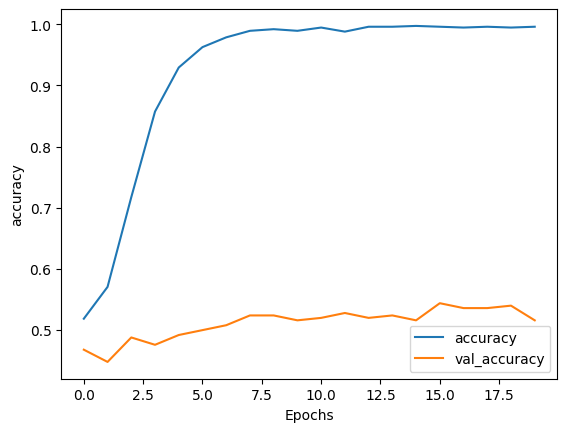

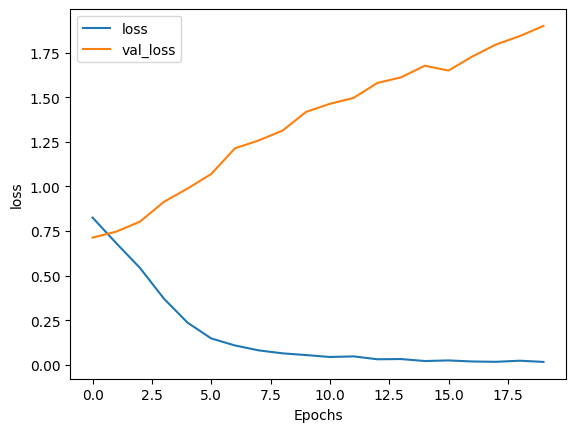

In [105]:
plot_graphs(history_rnn_4, "accuracy")
plot_graphs(history_rnn_4, "loss")

8/8 [==============================] - 1s 7ms/step
Accuracy: 0.516
Precision: 0.5314685314685315
Recall: 0.5846153846153846
F1-score: 0.5567765567765569


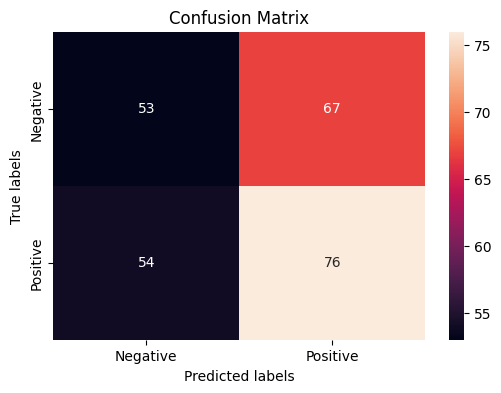

In [107]:
# Predict labels for testing data
predicted_labels = (model_rnn_4.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## GRU (2 Layers and 0.3 Dropout)

In [118]:
model_gru_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.GRU(units=64, return_sequences=True),  # First layer
    tf.keras.layers.GRU(units=128),  # Second layer
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_gru_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru_1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 30, 16)            65376     
                                                                 
 gru_4 (GRU)                 (None, 30, 64)            15744     
                                                                 
 gru_5 (GRU)                 (None, 128)               74496     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 155,745
Trainable params: 155,745
Non-trainable params: 0
_________________________________________________________________


In [119]:
num_epochs = 30
history_gru_1 = model_gru_1.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 8s 74ms/step - loss: 0.6944 - accuracy: 0.4853 - val_loss: 0.6931 - val_accuracy: 0.5200
Epoch 2/30
24/24 [==============================] - 1s 38ms/step - loss: 0.6938 - accuracy: 0.4880 - val_loss: 0.6937 - val_accuracy: 0.4800
Epoch 3/30
24/24 [==============================] - 1s 39ms/step - loss: 0.6938 - accuracy: 0.5013 - val_loss: 0.6939 - val_accuracy: 0.4800
Epoch 4/30
24/24 [==============================] - 1s 38ms/step - loss: 0.6933 - accuracy: 0.4920 - val_loss: 0.6935 - val_accuracy: 0.4720
Epoch 5/30
24/24 [==============================] - 1s 39ms/step - loss: 0.6933 - accuracy: 0.5107 - val_loss: 0.6954 - val_accuracy: 0.4760
Epoch 6/30
24/24 [==============================] - 1s 38ms/step - loss: 0.6575 - accuracy: 0.6000 - val_loss: 0.7351 - val_accuracy: 0.4840
Epoch 7/30
24/24 [==============================] - 1s 39ms/step - loss: 0.3630 - accuracy: 0.8467 - val_loss: 1.0437 - val_accuracy: 0.5360
Epoch 8/30
24

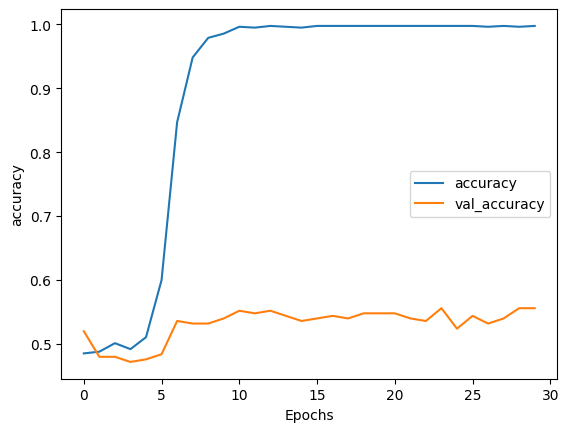

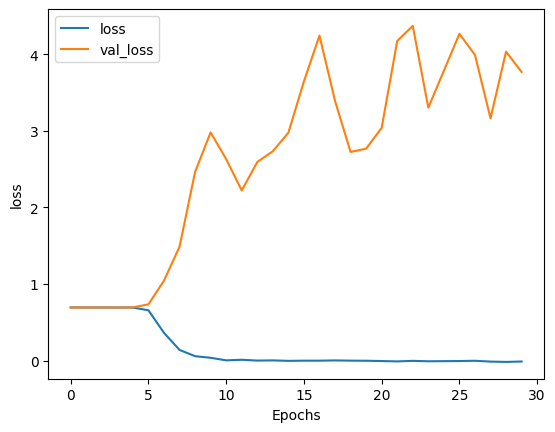

In [120]:
plot_graphs(history_gru_1, "accuracy")
plot_graphs(history_gru_1, "loss")

8/8 [==============================] - 1s 17ms/step
Accuracy: 0.556
Precision: 0.5524861878453039
Recall: 0.7692307692307693
F1-score: 0.6430868167202572


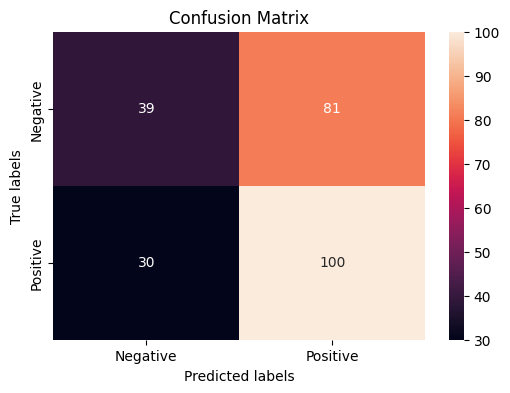

In [121]:
# Predict labels for testing data
predicted_labels = (model_gru_1.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## GRU (2 Layers and 0.7 Dropout)

In [122]:
model_gru_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.GRU(units=64, return_sequences=True),  # First layer
    tf.keras.layers.GRU(units=128),  # Second layer
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_gru_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru_2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 30, 16)            65376     
                                                                 
 gru_6 (GRU)                 (None, 30, 64)            15744     
                                                                 
 gru_7 (GRU)                 (None, 128)               74496     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 155,745
Trainable params: 155,745
Non-trainable params: 0
_________________________________________________________________


In [123]:
num_epochs = 30
history_gru_2 = model_gru_2.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30


24/24 [==============================] - 8s 79ms/step - loss: 0.6934 - accuracy: 0.5013 - val_loss: 0.6939 - val_accuracy: 0.4800
Epoch 2/30
24/24 [==============================] - 1s 46ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5200
Epoch 3/30
24/24 [==============================] - 1s 39ms/step - loss: 0.6943 - accuracy: 0.4720 - val_loss: 0.6951 - val_accuracy: 0.4800
Epoch 4/30
24/24 [==============================] - 1s 38ms/step - loss: 0.6924 - accuracy: 0.4973 - val_loss: 0.6934 - val_accuracy: 0.4680
Epoch 5/30
24/24 [==============================] - 1s 42ms/step - loss: 0.6942 - accuracy: 0.5027 - val_loss: 0.6960 - val_accuracy: 0.4800
Epoch 6/30
24/24 [==============================] - 1s 38ms/step - loss: 0.6955 - accuracy: 0.4800 - val_loss: 0.6923 - val_accuracy: 0.5200
Epoch 7/30
24/24 [==============================] - 1s 38ms/step - loss: 0.6135 - accuracy: 0.6667 - val_loss: 0.7205 - val_accuracy: 0.5600
Epoch 8/30
24/24 [======

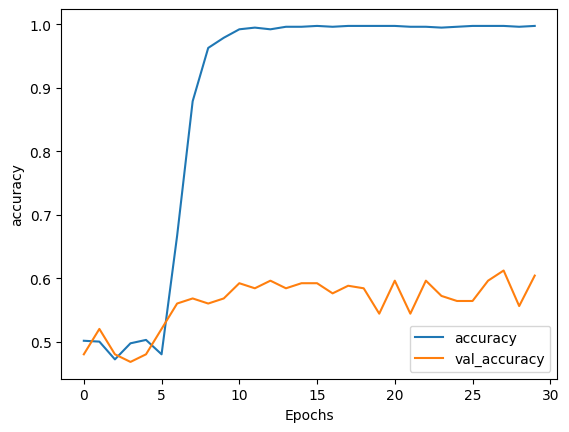

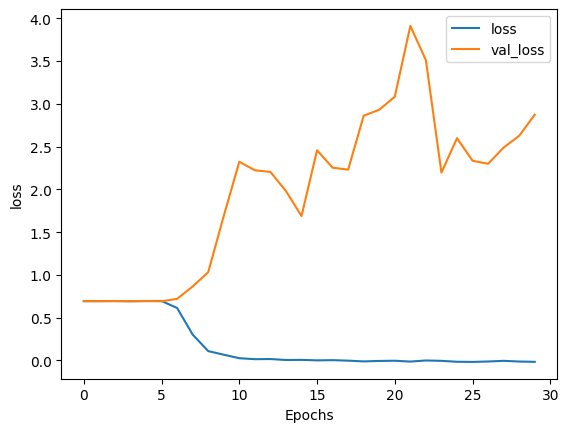

In [124]:
plot_graphs(history_gru_2, "accuracy")
plot_graphs(history_gru_2, "loss")

8/8 [==============================] - 1s 18ms/step
Accuracy: 0.604
Precision: 0.624
Recall: 0.6
F1-score: 0.611764705882353


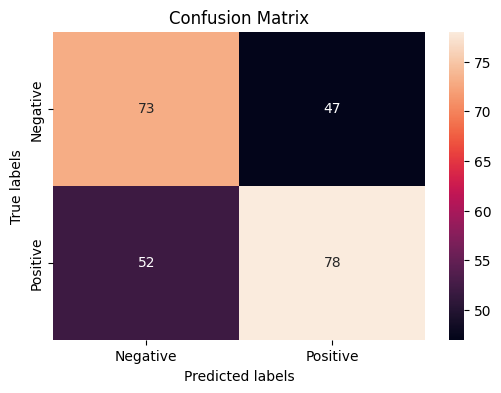

In [125]:
# Predict labels for testing data
predicted_labels = (model_gru_2.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## GRU (3 Layers and 0.3 Dropout)

In [127]:
model_gru_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.GRU(units=64, return_sequences=True),  # First layer
    tf.keras.layers.GRU(units=128,return_sequences=True),  # Second layer
    tf.keras.layers.GRU(units=64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_gru_3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru_3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 30, 16)            65376     
                                                                 
 gru_11 (GRU)                (None, 30, 64)            15744     
                                                                 
 gru_12 (GRU)                (None, 30, 128)           74496     
                                                                 
 gru_13 (GRU)                (None, 64)                37248     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 192,929
Trainable params: 192,929
Non-t

In [128]:
num_epochs = 30
history_gru_3 = model_gru_3.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 10s 96ms/step - loss: 0.6944 - accuracy: 0.4973 - val_loss: 0.6927 - val_accuracy: 0.5200
Epoch 2/30
24/24 [==============================] - 1s 51ms/step - loss: 0.6931 - accuracy: 0.4933 - val_loss: 0.6933 - val_accuracy: 0.4720
Epoch 3/30
24/24 [==============================] - 1s 49ms/step - loss: 0.6941 - accuracy: 0.4973 - val_loss: 0.6935 - val_accuracy: 0.4680
Epoch 4/30
24/24 [==============================] - 1s 49ms/step - loss: 0.6927 - accuracy: 0.5093 - val_loss: 0.6939 - val_accuracy: 0.4720
Epoch 5/30
24/24 [==============================] - 1s 50ms/step - loss: 0.6565 - accuracy: 0.5973 - val_loss: 0.6668 - val_accuracy: 0.5720
Epoch 6/30
24/24 [==============================] - 1s 50ms/step - loss: 0.3922 - accuracy: 0.8400 - val_loss: 0.6584 - val_accuracy: 0.6160
Epoch 7/30
24/24 [==============================] - 1s 51ms/step - loss: 0.1447 - accuracy: 0.9587 - val_loss: 1.4315 - val_accuracy: 0.5640
Epoch 8/30
2

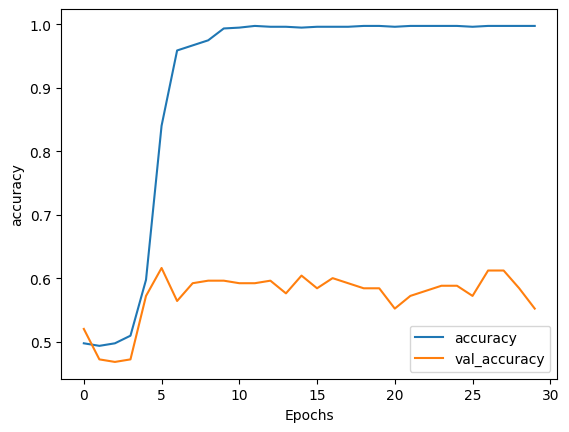

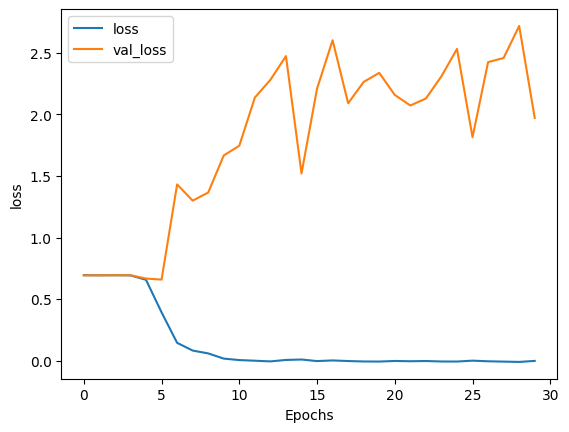

In [130]:
plot_graphs(history_gru_3, "accuracy")
plot_graphs(history_gru_3, "loss")

8/8 [==============================] - 2s 19ms/step
Accuracy: 0.552
Precision: 0.6363636363636364
Recall: 0.3230769230769231
F1-score: 0.4285714285714286


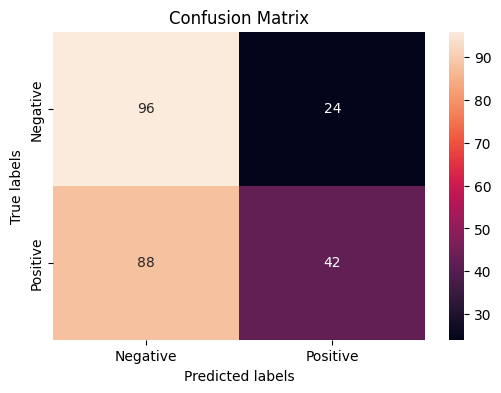

In [132]:
# Predict labels for testing data
predicted_labels = (model_gru_3.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## GRU (3 Layers and 0.7 Dropout)

In [133]:
model_gru_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.GRU(units=64, return_sequences=True),  # First layer
    tf.keras.layers.GRU(units=128,return_sequences=True),  # Second layer
    tf.keras.layers.GRU(units=64),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_gru_4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru_4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 30, 16)            65376     
                                                                 
 gru_14 (GRU)                (None, 30, 64)            15744     
                                                                 
 gru_15 (GRU)                (None, 30, 128)           74496     
                                                                 
 gru_16 (GRU)                (None, 64)                37248     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 192,929
Trainable params: 192,929
Non-t

In [134]:
num_epochs = 30
history_gru_4 = model_gru_4.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 11s 103ms/step - loss: 0.6930 - accuracy: 0.5080 - val_loss: 0.6930 - val_accuracy: 0.5200
Epoch 2/30
24/24 [==============================] - 1s 51ms/step - loss: 0.6934 - accuracy: 0.5053 - val_loss: 0.6933 - val_accuracy: 0.4480
Epoch 3/30
24/24 [==============================] - 1s 54ms/step - loss: 0.6962 - accuracy: 0.5053 - val_loss: 0.6939 - val_accuracy: 0.4760
Epoch 4/30
24/24 [==============================] - 1s 54ms/step - loss: 0.6943 - accuracy: 0.5093 - val_loss: 0.6954 - val_accuracy: 0.4800
Epoch 5/30
24/24 [==============================] - 1s 51ms/step - loss: 0.6945 - accuracy: 0.5080 - val_loss: 0.6949 - val_accuracy: 0.4800
Epoch 6/30
24/24 [==============================] - 1s 51ms/step - loss: 0.6915 - accuracy: 0.5173 - val_loss: 0.6937 - val_accuracy: 0.4720
Epoch 7/30
24/24 [==============================] - 1s 56ms/step - loss: 0.6936 - accuracy: 0.4813 - val_loss: 0.6939 - val_accuracy: 0.5200
Epoch 8/30


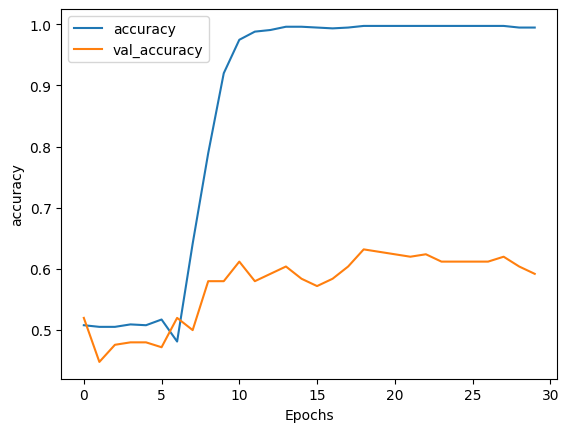

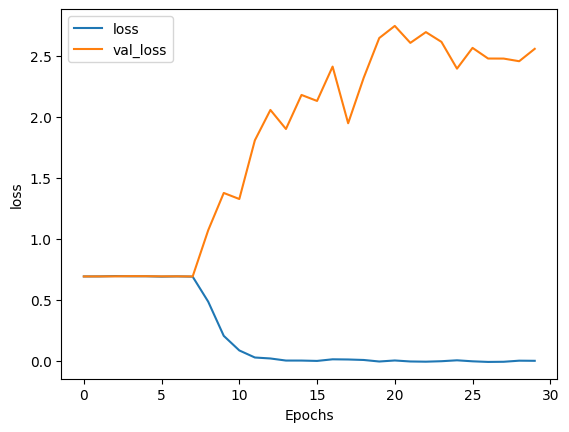

In [135]:
plot_graphs(history_gru_4, "accuracy")
plot_graphs(history_gru_4, "loss")

8/8 [==============================] - 2s 24ms/step
Accuracy: 0.592
Precision: 0.5958904109589042
Recall: 0.6692307692307692
F1-score: 0.6304347826086957


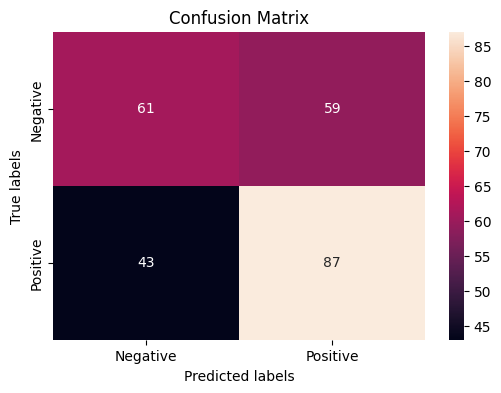

In [136]:
# Predict labels for testing data
predicted_labels = (model_gru_4.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## LSTM (2 Layers and 0.3 Dropout)

In [139]:
model_lstm_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.LSTM(units=64, return_sequences=True),  # First layer
    tf.keras.layers.LSTM(units=128),  # Second layer
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_lstm_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm_1.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 30, 16)            65376     
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            20736     
                                                                 
 lstm_3 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 185,057
Trainable params: 185,057
Non-trainable params: 0
_________________________________________________________________


In [140]:
num_epochs = 30
history_lstm_1 = model_lstm_1.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 8s 94ms/step - loss: 0.6936 - accuracy: 0.5027 - val_loss: 0.6945 - val_accuracy: 0.4800
Epoch 2/30
24/24 [==============================] - 1s 51ms/step - loss: 0.6949 - accuracy: 0.4800 - val_loss: 0.6933 - val_accuracy: 0.4640
Epoch 3/30
24/24 [==============================] - 1s 47ms/step - loss: 0.6688 - accuracy: 0.6027 - val_loss: 0.9084 - val_accuracy: 0.5360
Epoch 4/30
24/24 [==============================] - 1s 48ms/step - loss: 0.2945 - accuracy: 0.8853 - val_loss: 0.8814 - val_accuracy: 0.5320
Epoch 5/30
24/24 [==============================] - 1s 57ms/step - loss: 0.0768 - accuracy: 0.9800 - val_loss: 2.1008 - val_accuracy: 0.5640
Epoch 6/30
24/24 [==============================] - 1s 49ms/step - loss: 0.0400 - accuracy: 0.9840 - val_loss: 1.7204 - val_accuracy: 0.5720
Epoch 7/30
24/24 [==============================] - 1s 47ms/step - loss: 0.0238 - accuracy: 0.9920 - val_loss: 2.8255 - val_accuracy: 0.5480
Epoch 8/30
24

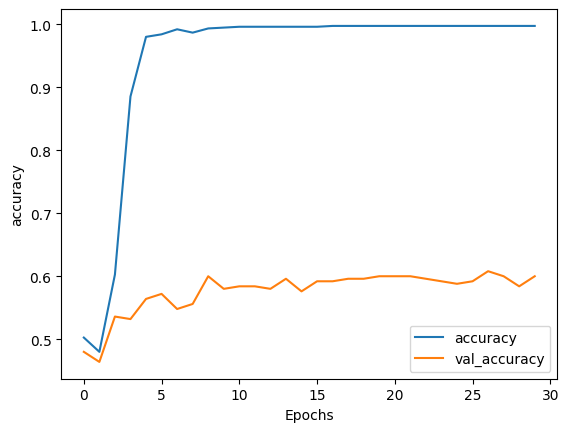

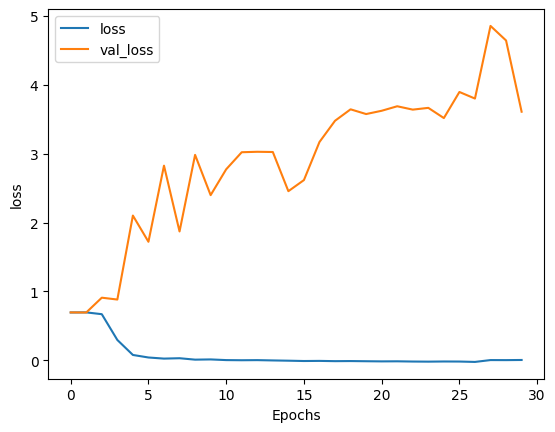

In [142]:
plot_graphs(history_lstm_1, "accuracy")
plot_graphs(history_lstm_1, "loss")

8/8 [==============================] - 1s 18ms/step
Accuracy: 0.6
Precision: 0.6
Recall: 0.6923076923076923
F1-score: 0.6428571428571429


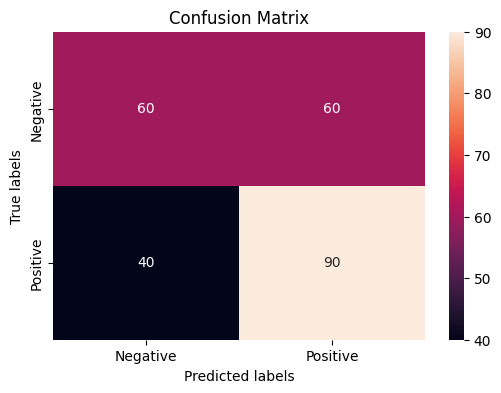

In [143]:
# Predict labels for testing data
predicted_labels = (model_lstm_1.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## LSTM (2 Layers and 0.7 Dropout)

In [145]:
model_lstm_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.LSTM(units=64, return_sequences=True),  # First layer
    tf.keras.layers.LSTM(units=128),  # Second layer
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_lstm_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm_2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 30, 16)            65376     
                                                                 
 lstm_6 (LSTM)               (None, 30, 64)            20736     
                                                                 
 lstm_7 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 185,057
Trainable params: 185,057
Non-trainable params: 0
_________________________________________________________________


In [146]:
num_epochs = 30
history_lstm_2 = model_lstm_2.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 7s 80ms/step - loss: 0.6944 - accuracy: 0.4600 - val_loss: 0.6936 - val_accuracy: 0.4800
Epoch 2/30
24/24 [==============================] - 1s 42ms/step - loss: 0.6932 - accuracy: 0.5067 - val_loss: 0.6929 - val_accuracy: 0.5720
Epoch 3/30
24/24 [==============================] - 1s 41ms/step - loss: 0.6892 - accuracy: 0.5427 - val_loss: 0.6864 - val_accuracy: 0.6040
Epoch 4/30
24/24 [==============================] - 1s 44ms/step - loss: 0.4426 - accuracy: 0.8307 - val_loss: 0.8079 - val_accuracy: 0.5440
Epoch 5/30
24/24 [==============================] - 1s 44ms/step - loss: 0.1381 - accuracy: 0.9613 - val_loss: 1.1067 - val_accuracy: 0.5760
Epoch 6/30
24/24 [==============================] - 1s 43ms/step - loss: 0.0325 - accuracy: 0.9867 - val_loss: 1.8653 - val_accuracy: 0.5920
Epoch 7/30
24/24 [==============================] - 1s 42ms/step - loss: 0.0389 - accuracy: 0.9853 - val_loss: 1.9371 - val_accuracy: 0.5800
Epoch 8/30
24

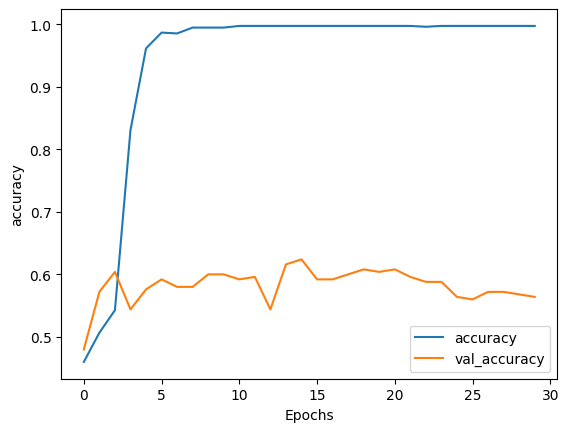

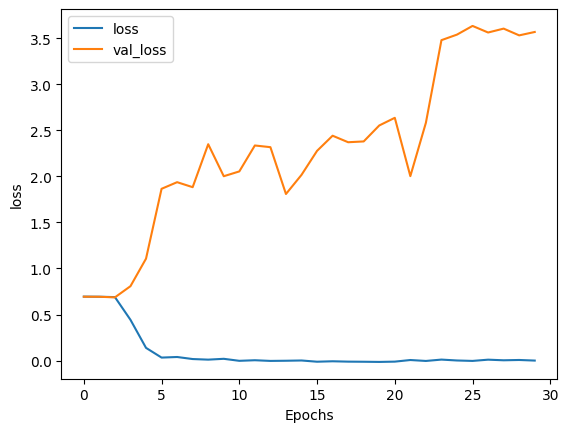

In [148]:
plot_graphs(history_lstm_2, "accuracy")
plot_graphs(history_lstm_2, "loss")

8/8 [==============================] - 1s 25ms/step
Accuracy: 0.564
Precision: 0.6129032258064516
Recall: 0.43846153846153846
F1-score: 0.5112107623318385


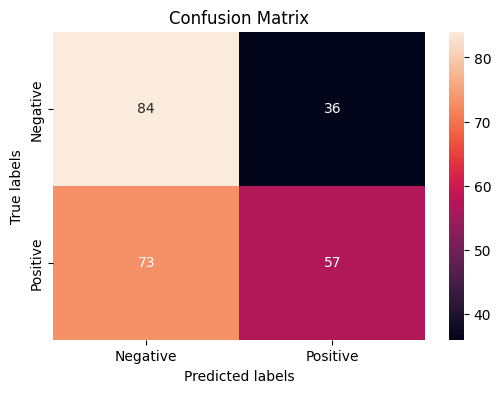

In [149]:
# Predict labels for testing data
predicted_labels = (model_lstm_2.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## LSTM (3 Layers and 0.3 Dropout)

In [150]:
model_lstm_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.LSTM(units=64, return_sequences=True),  # First layer
     tf.keras.layers.LSTM(units=128, return_sequences=True),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_lstm_3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm_3.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 30, 16)            65376     
                                                                 
 lstm_8 (LSTM)               (None, 30, 64)            20736     
                                                                 
 lstm_9 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 234,401
Trainable params: 234,401
Non-t

In [151]:
num_epochs = 30
history_lstm_3 = model_lstm_3.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 11s 127ms/step - loss: 0.6946 - accuracy: 0.4920 - val_loss: 0.6924 - val_accuracy: 0.5200
Epoch 2/30
24/24 [==============================] - 1s 57ms/step - loss: 0.6932 - accuracy: 0.4693 - val_loss: 0.6934 - val_accuracy: 0.4760
Epoch 3/30
24/24 [==============================] - 2s 66ms/step - loss: 0.6820 - accuracy: 0.5653 - val_loss: 0.7735 - val_accuracy: 0.5120
Epoch 4/30
24/24 [==============================] - 1s 62ms/step - loss: 0.3429 - accuracy: 0.8587 - val_loss: 0.8461 - val_accuracy: 0.5800
Epoch 5/30
24/24 [==============================] - 2s 66ms/step - loss: 0.1013 - accuracy: 0.9693 - val_loss: 1.1610 - val_accuracy: 0.5640
Epoch 6/30
24/24 [==============================] - 2s 69ms/step - loss: 0.0576 - accuracy: 0.9760 - val_loss: 1.7468 - val_accuracy: 0.5800
Epoch 7/30
24/24 [==============================] - 1s 61ms/step - loss: 0.0300 - accuracy: 0.9880 - val_loss: 1.4640 - val_accuracy: 0.5960
Epoch 8/30


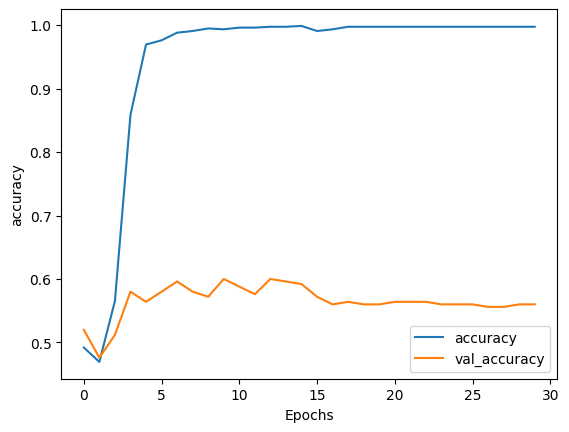

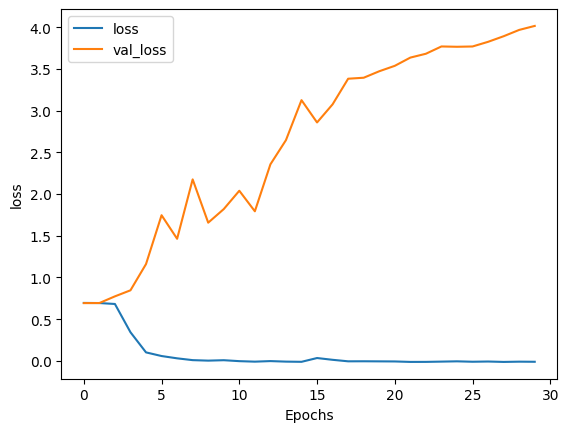

In [153]:
plot_graphs(history_lstm_3, "accuracy")
plot_graphs(history_lstm_3, "loss")

8/8 [==============================] - 2s 27ms/step
Accuracy: 0.56
Precision: 0.5704225352112676
Recall: 0.6230769230769231
F1-score: 0.5955882352941178


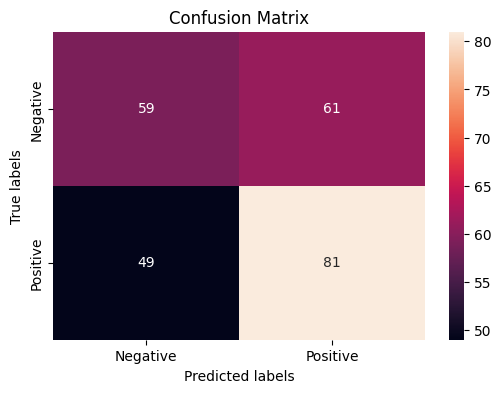

In [154]:
# Predict labels for testing data
predicted_labels = (model_lstm_3.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## LSTM (3 Layers and 0.7 Dropout)

In [152]:
model_lstm_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.LSTM(units=64, return_sequences=True),  # First layer
     tf.keras.layers.LSTM(units=128, return_sequences=True),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_lstm_4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm_4.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 30, 16)            65376     
                                                                 
 lstm_11 (LSTM)              (None, 30, 64)            20736     
                                                                 
 lstm_12 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 234,401
Trainable params: 234,401
Non-t

In [155]:
num_epochs = 30
history_lstm_4 = model_lstm_4.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 11s 126ms/step - loss: 0.6967 - accuracy: 0.4773 - val_loss: 0.6926 - val_accuracy: 0.5200
Epoch 2/30
24/24 [==============================] - 2s 66ms/step - loss: 0.6939 - accuracy: 0.4827 - val_loss: 0.6939 - val_accuracy: 0.4800
Epoch 3/30
24/24 [==============================] - 2s 66ms/step - loss: 0.6769 - accuracy: 0.5427 - val_loss: 0.8168 - val_accuracy: 0.5480
Epoch 4/30
24/24 [==============================] - 2s 65ms/step - loss: 0.3470 - accuracy: 0.8613 - val_loss: 0.9829 - val_accuracy: 0.5800
Epoch 5/30
24/24 [==============================] - 1s 62ms/step - loss: 0.1269 - accuracy: 0.9640 - val_loss: 0.9747 - val_accuracy: 0.5840
Epoch 6/30
24/24 [==============================] - 2s 64ms/step - loss: 0.0524 - accuracy: 0.9853 - val_loss: 1.3614 - val_accuracy: 0.5720
Epoch 7/30
24/24 [==============================] - 1s 62ms/step - loss: 0.0115 - accuracy: 0.9973 - val_loss: 2.8877 - val_accuracy: 0.5520
Epoch 8/30


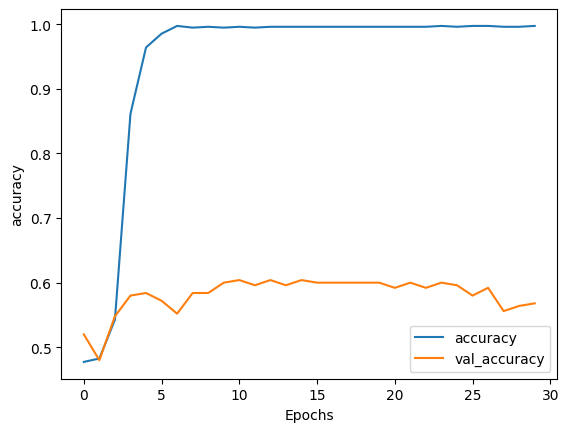

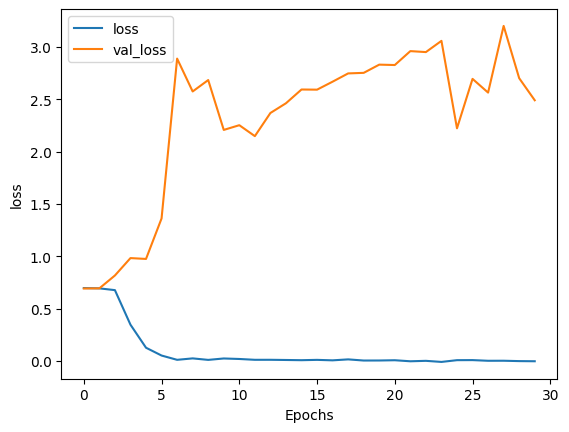

In [156]:
plot_graphs(history_lstm_4, "accuracy")
plot_graphs(history_lstm_4, "loss")

8/8 [==============================] - 3s 24ms/step
Accuracy: 0.568
Precision: 0.569620253164557
Recall: 0.6923076923076923
F1-score: 0.625


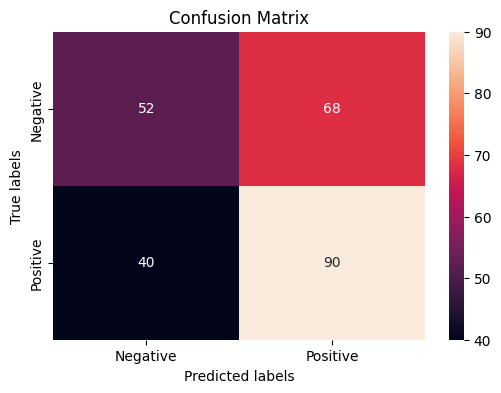

In [158]:
# Predict labels for testing data
predicted_labels = (model_lstm_4.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## Bi-LSTM (2 Layers and 0.3 Dropout)

In [159]:
model_bilstm_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),  # First BiLSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128)),  # Second BiLSTM layer
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_bilstm_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm_1.summary()


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 30, 16)            65376     
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          41472     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 257       
                                                                 
Total params: 370,273
Trainable params: 370,273
Non-t

In [160]:
num_epochs = 30
history_bilstm_1 = model_bilstm_1.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 12s 148ms/step - loss: 0.6942 - accuracy: 0.5093 - val_loss: 0.6917 - val_accuracy: 0.5200
Epoch 2/30
24/24 [==============================] - 2s 68ms/step - loss: 0.6893 - accuracy: 0.4987 - val_loss: 0.6913 - val_accuracy: 0.5120
Epoch 3/30
24/24 [==============================] - 2s 70ms/step - loss: 0.4366 - accuracy: 0.8667 - val_loss: 0.8825 - val_accuracy: 0.5840
Epoch 4/30
24/24 [==============================] - 2s 72ms/step - loss: 0.1109 - accuracy: 0.9627 - val_loss: 0.9275 - val_accuracy: 0.6000
Epoch 5/30
24/24 [==============================] - 2s 69ms/step - loss: 0.0632 - accuracy: 0.9787 - val_loss: 1.1421 - val_accuracy: 0.6200
Epoch 6/30
24/24 [==============================] - 2s 68ms/step - loss: 0.0176 - accuracy: 0.9920 - val_loss: 1.9641 - val_accuracy: 0.6040
Epoch 7/30
24/24 [==============================] - 2s 71ms/step - loss: 0.0080 - accuracy: 0.9960 - val_loss: 1.5784 - val_accuracy: 0.6040
Epoch 8/30


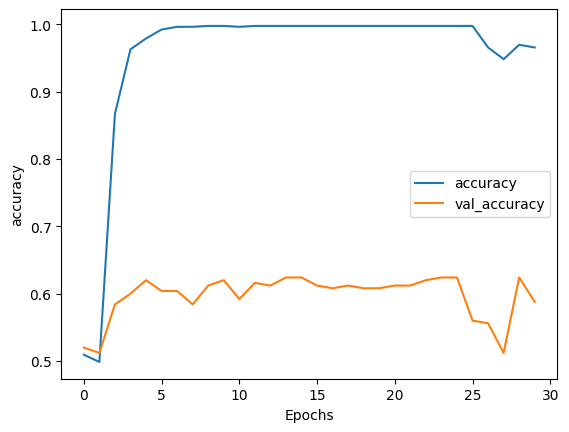

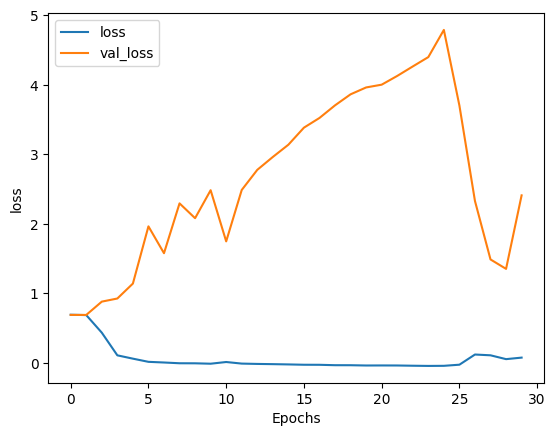

In [161]:
plot_graphs(history_bilstm_1, "accuracy")
plot_graphs(history_bilstm_1, "loss")

8/8 [==============================] - 2s 27ms/step
Accuracy: 0.588
Precision: 0.6153846153846154
Recall: 0.5538461538461539
F1-score: 0.5829959514170041


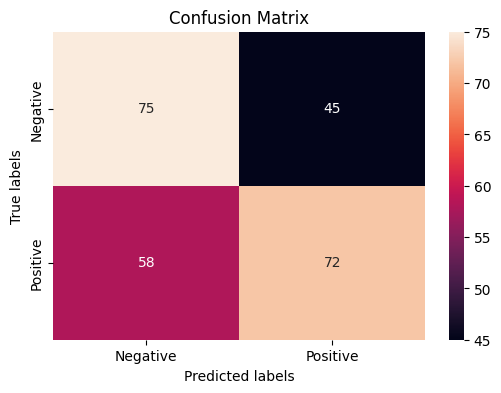

In [162]:
# Predict labels for testing data
predicted_labels = (model_bilstm_1.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## Bi-LSTM (2 Layers and 0.7 Dropout)

In [163]:
model_bilstm_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),  # First BiLSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128)),  # Second BiLSTM layer
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_bilstm_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm_2.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 30, 16)            65376     
                                                                 
 bidirectional_2 (Bidirectio  (None, 30, 128)          41472     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 1)                 257       
                                                                 
Total params: 370,273
Trainable params: 370,273
Non-t

In [164]:
num_epochs = 30
history_bilstm_2 = model_bilstm_2.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 13s 158ms/step - loss: 0.6949 - accuracy: 0.4667 - val_loss: 0.6930 - val_accuracy: 0.5120
Epoch 2/30
24/24 [==============================] - 2s 71ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6922 - val_accuracy: 0.5760
Epoch 3/30
24/24 [==============================] - 2s 77ms/step - loss: 0.6720 - accuracy: 0.6373 - val_loss: 0.8155 - val_accuracy: 0.5880
Epoch 4/30
24/24 [==============================] - 2s 75ms/step - loss: 0.2158 - accuracy: 0.9253 - val_loss: 0.8877 - val_accuracy: 0.6160
Epoch 5/30
24/24 [==============================] - 2s 75ms/step - loss: 0.0823 - accuracy: 0.9747 - val_loss: 1.7096 - val_accuracy: 0.6120
Epoch 6/30
24/24 [==============================] - 2s 77ms/step - loss: 0.0394 - accuracy: 0.9853 - val_loss: 1.5213 - val_accuracy: 0.6080
Epoch 7/30
24/24 [==============================] - 2s 73ms/step - loss: 0.0193 - accuracy: 0.9933 - val_loss: 1.5874 - val_accuracy: 0.6000
Epoch 8/30


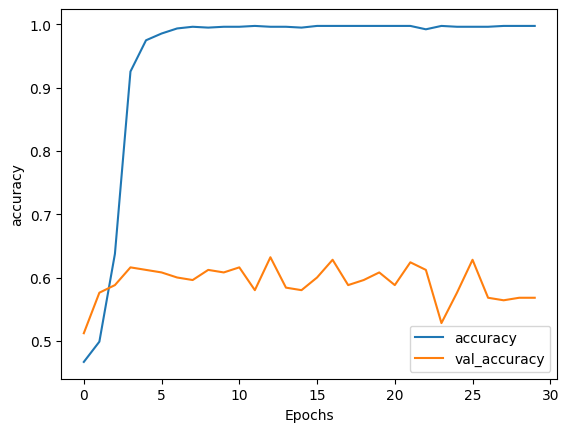

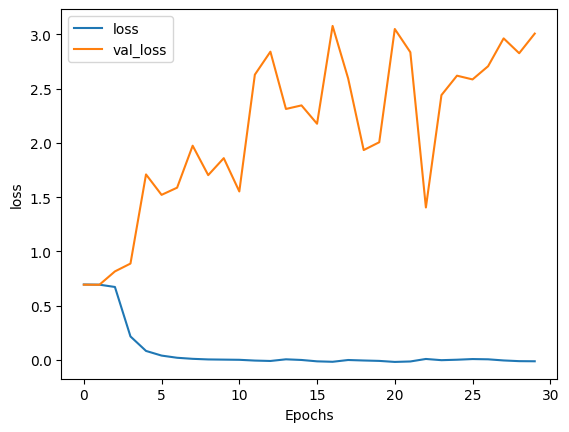

In [165]:
plot_graphs(history_bilstm_2, "accuracy")
plot_graphs(history_bilstm_2, "loss")

8/8 [==============================] - 2s 22ms/step
Accuracy: 0.568
Precision: 0.6571428571428571
Recall: 0.35384615384615387
F1-score: 0.4600000000000001


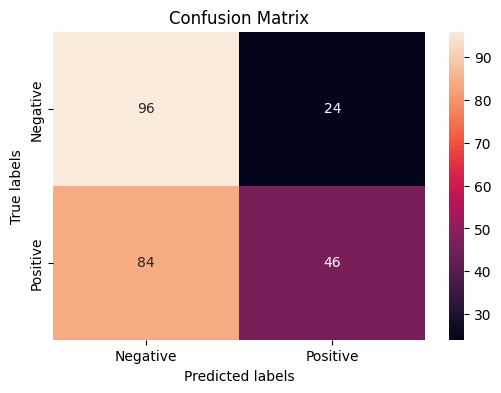

In [166]:
# Predict labels for testing data
predicted_labels = (model_bilstm_2.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## Bi-LSTM (3 Layers and 0.3 Dropout)

In [168]:
model_bilstm_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),  # First BiLSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),  # Second BiLSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),  # Third BiLSTM layer
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_bilstm_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm_3.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 30, 16)            65376     
                                                                 
 bidirectional_7 (Bidirectio  (None, 30, 128)          41472     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 30, 256)          263168    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                     

In [169]:
num_epochs = 30
history_bilstm_3 = model_bilstm_3.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 19s 208ms/step - loss: 0.6943 - accuracy: 0.5053 - val_loss: 0.6924 - val_accuracy: 0.5200
Epoch 2/30
24/24 [==============================] - 2s 95ms/step - loss: 0.6621 - accuracy: 0.5960 - val_loss: 0.7500 - val_accuracy: 0.5840
Epoch 3/30
24/24 [==============================] - 2s 99ms/step - loss: 0.3164 - accuracy: 0.8853 - val_loss: 0.8168 - val_accuracy: 0.6200
Epoch 4/30
24/24 [==============================] - 2s 94ms/step - loss: 0.1066 - accuracy: 0.9627 - val_loss: 1.2482 - val_accuracy: 0.5840
Epoch 5/30
24/24 [==============================] - 2s 104ms/step - loss: 0.0367 - accuracy: 0.9867 - val_loss: 1.8480 - val_accuracy: 0.5800
Epoch 6/30
24/24 [==============================] - 2s 103ms/step - loss: 0.0055 - accuracy: 0.9960 - val_loss: 1.8948 - val_accuracy: 0.6120
Epoch 7/30
24/24 [==============================] - 2s 98ms/step - loss: -0.0020 - accuracy: 0.9960 - val_loss: 2.0465 - val_accuracy: 0.5640
Epoch 8/

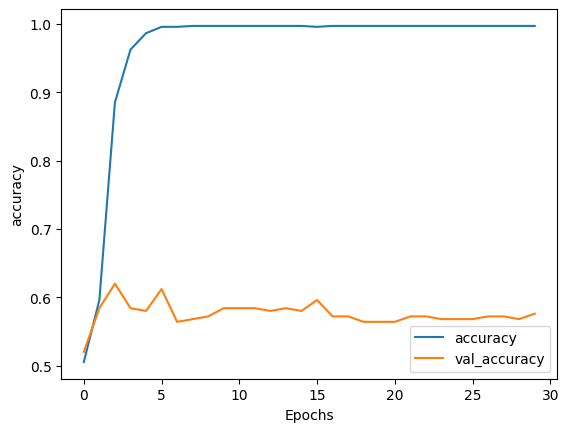

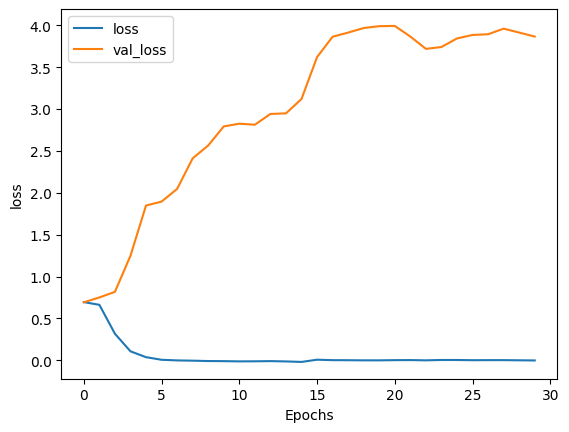

In [170]:
plot_graphs(history_bilstm_3, "accuracy")
plot_graphs(history_bilstm_3, "loss")

8/8 [==============================] - 3s 32ms/step
Accuracy: 0.576
Precision: 0.6463414634146342
Recall: 0.4076923076923077
F1-score: 0.5


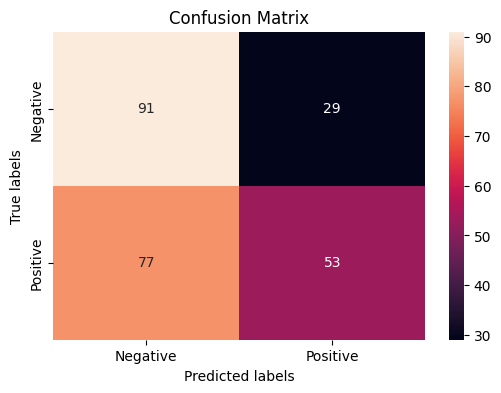

In [171]:
# Predict labels for testing data
predicted_labels = (model_bilstm_3.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


## Bi-LSTM (3 Layers and 0.7 Dropout)

In [172]:
model_bilstm_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_pad_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),  # First BiLSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),  # Second BiLSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),  # Third BiLSTM layer
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model_bilstm_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm_4.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 30, 16)            65376     
                                                                 
 bidirectional_10 (Bidirecti  (None, 30, 128)          41472     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 30, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                     

In [173]:
num_epochs = 30
history_bilstm_4 = model_bilstm_4.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
24/24 [==============================] - 18s 222ms/step - loss: 0.6944 - accuracy: 0.4960 - val_loss: 0.6928 - val_accuracy: 0.5200
Epoch 2/30
24/24 [==============================] - 2s 101ms/step - loss: 0.6881 - accuracy: 0.5427 - val_loss: 0.6973 - val_accuracy: 0.4840
Epoch 3/30
24/24 [==============================] - 2s 103ms/step - loss: 0.4491 - accuracy: 0.8067 - val_loss: 0.9446 - val_accuracy: 0.5520
Epoch 4/30
24/24 [==============================] - 2s 104ms/step - loss: 0.1662 - accuracy: 0.9440 - val_loss: 1.5189 - val_accuracy: 0.5360
Epoch 5/30
24/24 [==============================] - 2s 101ms/step - loss: 0.0584 - accuracy: 0.9760 - val_loss: 1.5243 - val_accuracy: 0.5560
Epoch 6/30
24/24 [==============================] - 2s 100ms/step - loss: 0.0058 - accuracy: 0.9933 - val_loss: 2.5514 - val_accuracy: 0.5240
Epoch 7/30
24/24 [==============================] - 2s 103ms/step - loss: 0.0173 - accuracy: 0.9933 - val_loss: 2.9025 - val_accuracy: 0.5720
Epoch

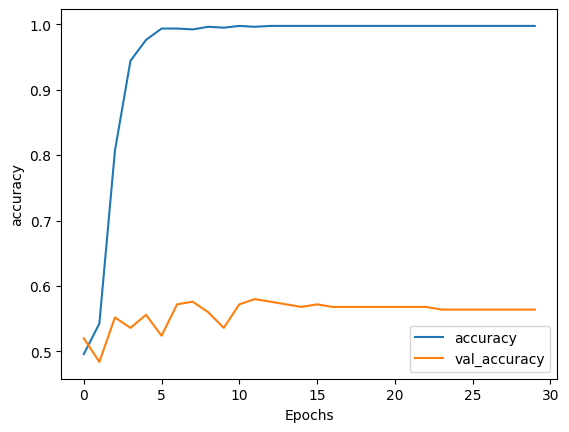

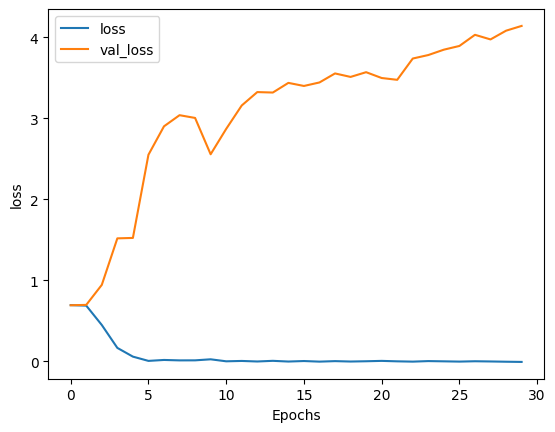

In [174]:
plot_graphs(history_bilstm_4, "accuracy")
plot_graphs(history_bilstm_4, "loss")

8/8 [==============================] - 3s 35ms/step
Accuracy: 0.564
Precision: 0.5686274509803921
Recall: 0.6692307692307692
F1-score: 0.6148409893992932


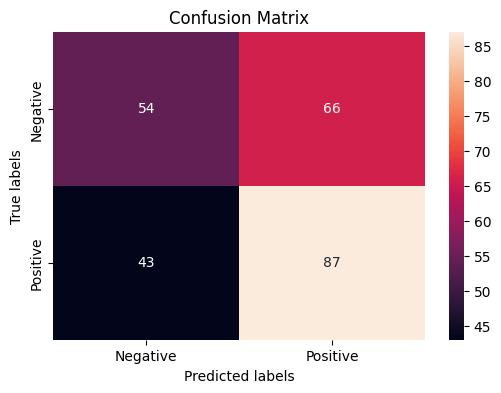

In [175]:
# Predict labels for testing data
predicted_labels = (model_bilstm_4.predict(testing_padded) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(testing_labels_final, predicted_labels)
precision = precision_score(testing_labels_final, predicted_labels)
recall = recall_score(testing_labels_final, predicted_labels)
f1 = f1_score(testing_labels_final, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot confusion matrix
cm = confusion_matrix(testing_labels_final, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
